<a href="https://colab.research.google.com/github/pinilDissanayaka/Pneumonia-Detection-using-Deep-Learning/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download tolgadincer/labeled-chest-xray-images

 98% 1.15G/1.17G [00:10<00:00, 93.8MB/s]
100% 1.17G/1.17G [00:10<00:00, 124MB/s] 


In [3]:
! unzip /content/labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
MAIN_DIR = '/content/chest_xray'

In [7]:
glob(MAIN_DIR + '/*')

['/content/chest_xray/test', '/content/chest_xray/train']

In [8]:
TRAIN_DIR = glob(MAIN_DIR + '/*')[1]
TEST_DIR = glob(MAIN_DIR + '/*')[0]


print(f"Training directory : {TRAIN_DIR}")
print(f"Testing directory : {TEST_DIR}")

Training directory : /content/chest_xray/train
Testing directory : /content/chest_xray/test


In [28]:
TRAIN_CATEGORIES = os.listdir(TRAIN_DIR)
TESTING_CATEGORIES = os.listdir(TEST_DIR)


print(f"Trainging categories : {TRAIN_CATEGORIES}")
print(f"Testing categories : {TESTING_CATEGORIES}")


OUT_SIZE = len(TRAIN_CATEGORIES)

Trainging categories : ['NORMAL', 'PNEUMONIA']
Testing categories : ['NORMAL', 'PNEUMONIA']


In [10]:
TRAIN_CATEGORIES == TESTING_CATEGORIES

True

In [11]:
for i in glob(MAIN_DIR + '/*'):
  path = glob(i + '/*')
  for j in path:
    imgCount = len(os.listdir(j))
    print(f"{j} has {imgCount} images.")
  print('\n')

/content/chest_xray/test/NORMAL has 234 images.
/content/chest_xray/test/PNEUMONIA has 390 images.


/content/chest_xray/train/NORMAL has 1349 images.
/content/chest_xray/train/PNEUMONIA has 3883 images.




TRAINING NORMAL


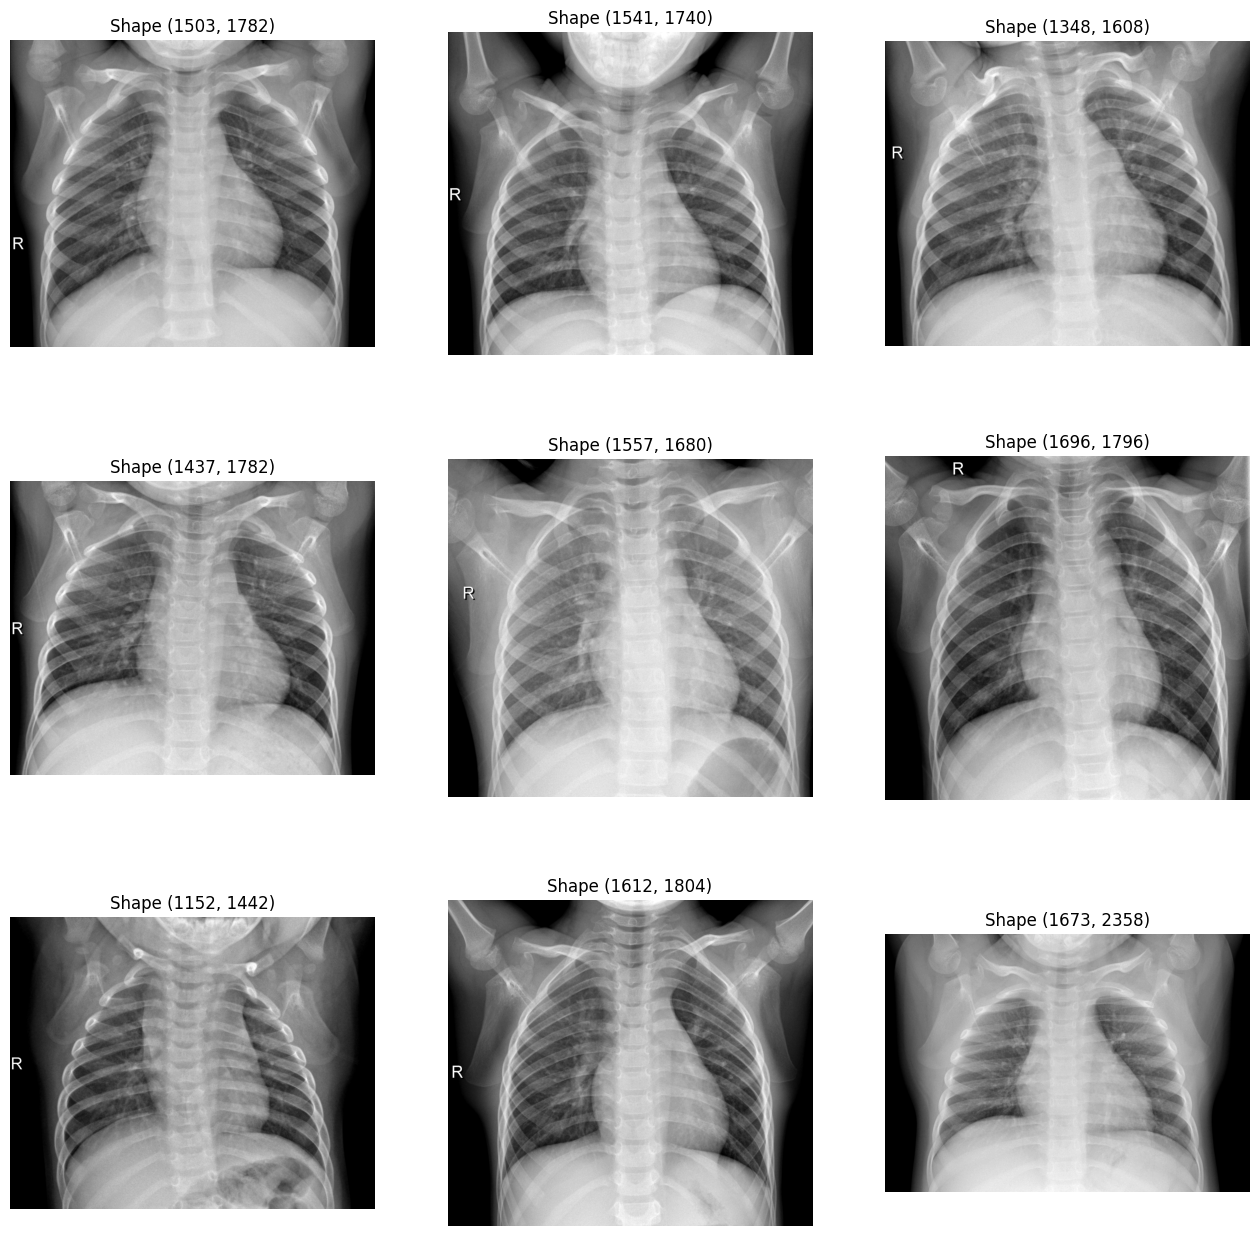

In [12]:
path = random.choices(list(glob(TRAIN_DIR + '/NORMAL/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING NORMAL')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

TRAINING PNEUMONIA


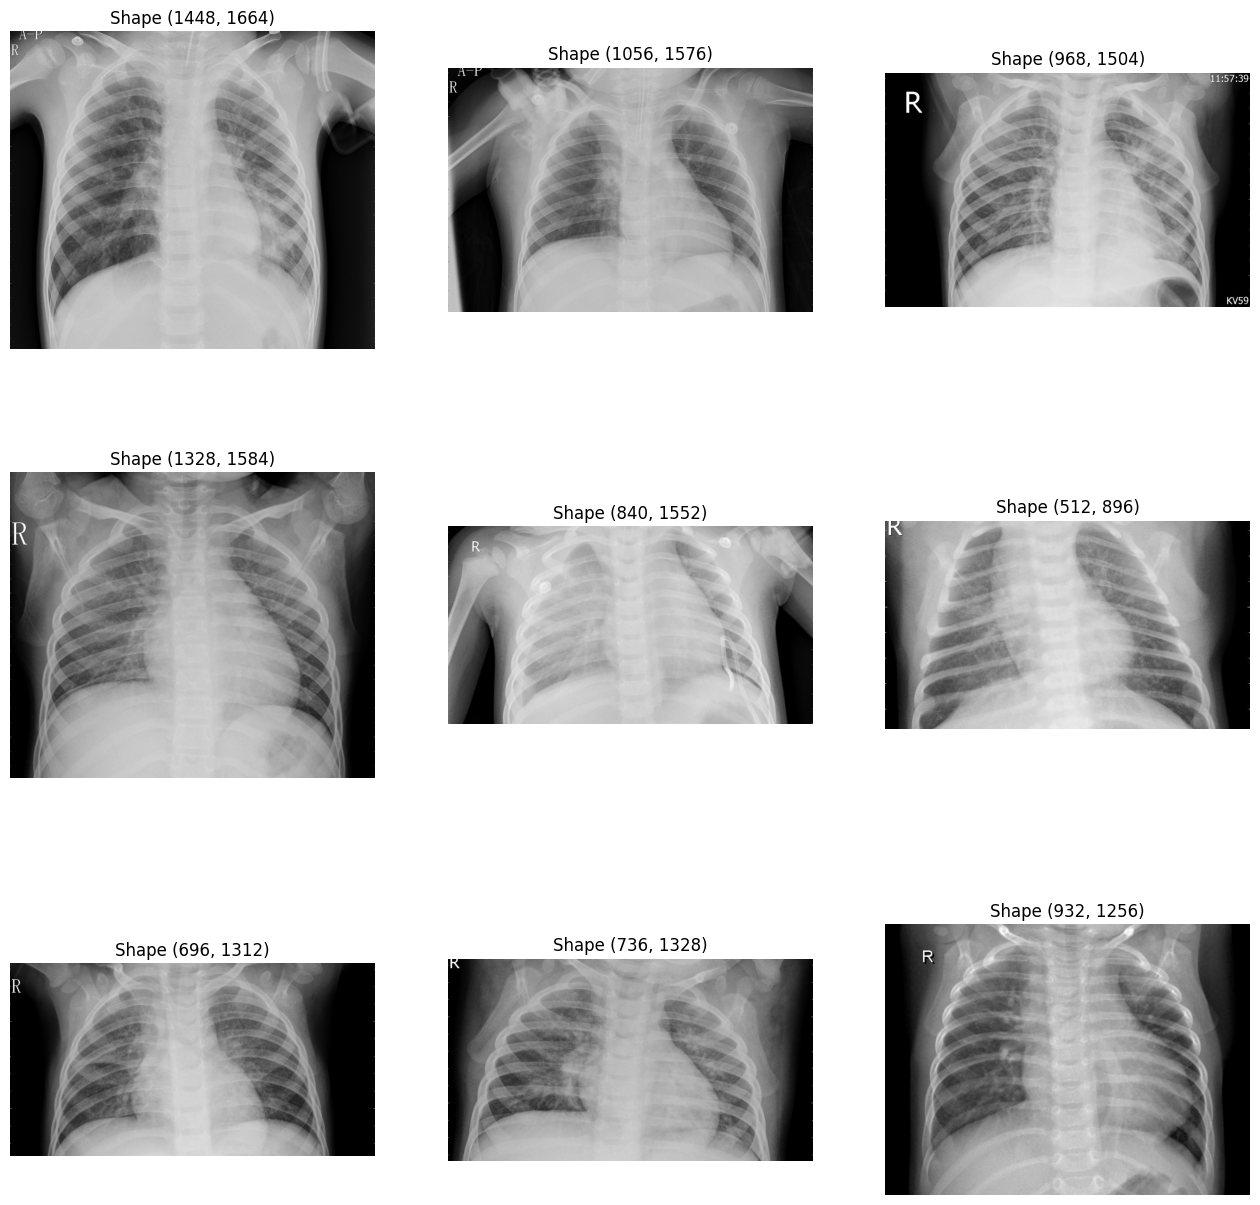

In [13]:
path = random.choices(list(glob(TRAIN_DIR + '/PNEUMONIA/*')), k = 9)
plt.figure(figsize = (16, 16))
print('TRAINING PNEUMONIA')
j = 1
for i in path:
  img = plt.imread(i)
  plt.subplot(3, 3, j)
  plt.imshow(img, cmap='gray')
  plt.title(f"Shape {img.shape}")
  plt.axis('off')
  j = j +1

In [24]:
rescale = 1./255
TARGET_SIZE = [150, 150]
INPUT_SHAPE = TARGET_SIZE + [3]
batch_size = 64
class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    class_mode=class_mode,
    batch_size= batch_size,
    shuffle = False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
TRAINING_STEPS = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = test_generator.n // test_generator.batch_size


print(f"Training epoch has {TRAINING_STEPS} steps.")
print(f"Validation epoch has {VALIDATION_STEPS} steps.")

Training epoch has 81 steps.
Validation epoch has 9 steps.


In [26]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [45]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape= INPUT_SHAPE))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1 , activation='sigmoid'))


    print(model.summary())

    return model

In [46]:
model = get_conv_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_39 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_41 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 37, 37, 32)        0         
 ng2D)                                                

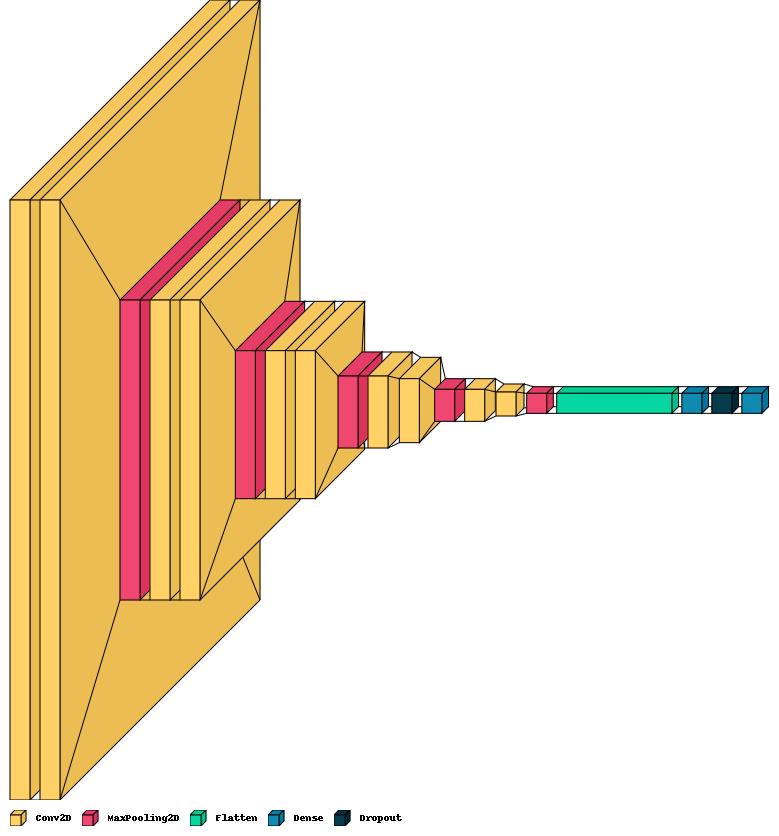

In [47]:
visualkeras.layered_view(model, legend=True)

In [48]:
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])

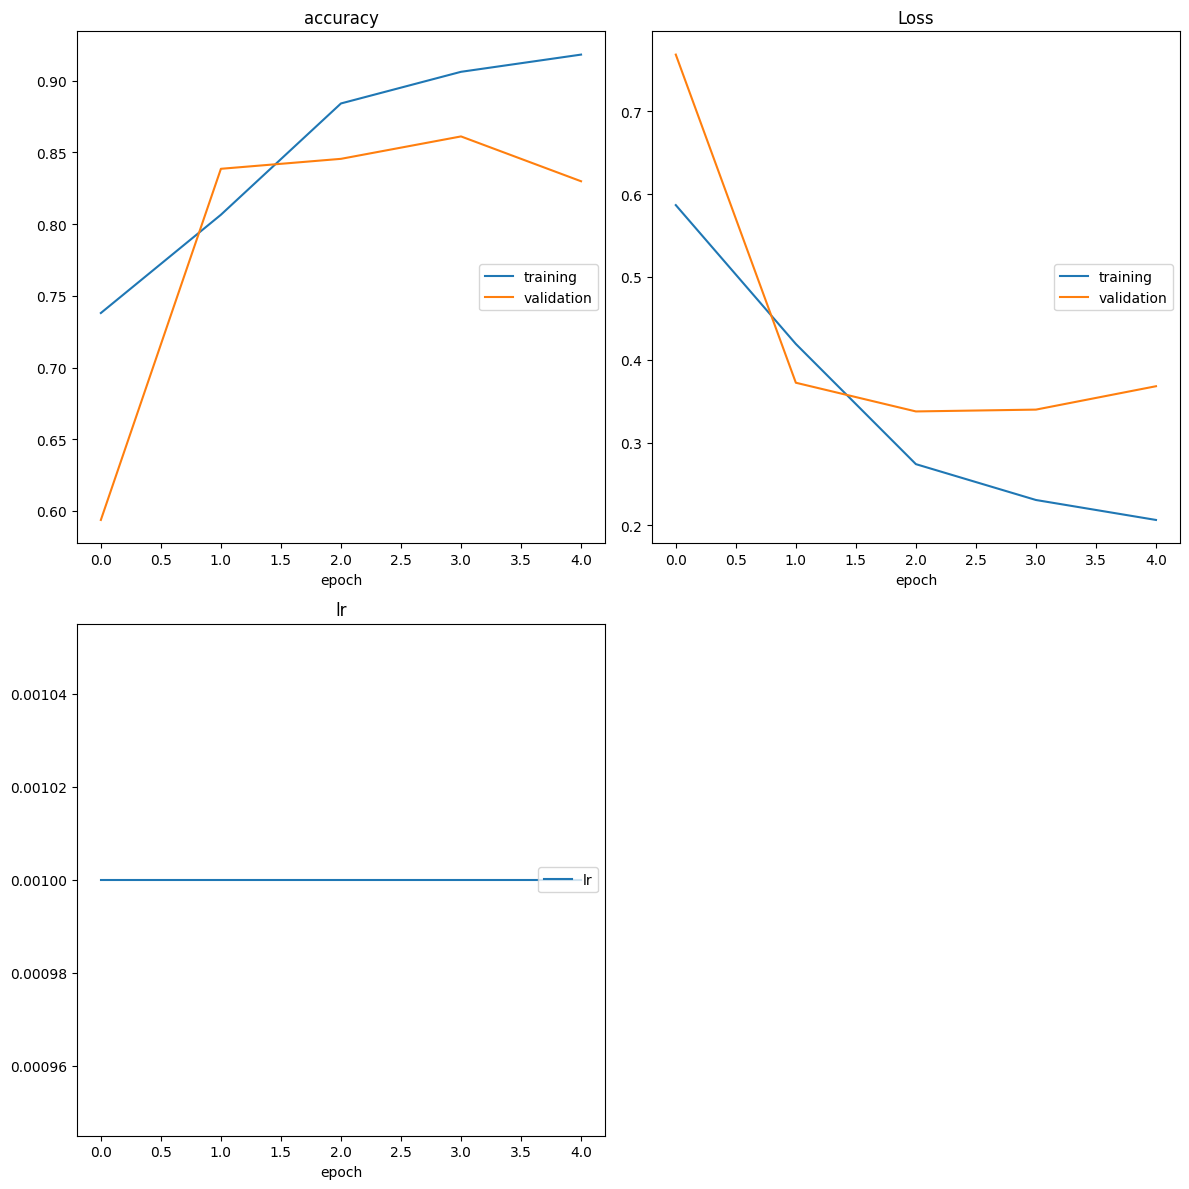

accuracy
	training         	 (min:    0.738, max:    0.918, cur:    0.918)
	validation       	 (min:    0.594, max:    0.861, cur:    0.830)
Loss
	training         	 (min:    0.207, max:    0.587, cur:    0.207)
	validation       	 (min:    0.338, max:    0.768, cur:    0.368)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
81/81 [==============================] - 75s 929ms/step - loss: 0.2066 - accuracy: 0.9182 - val_loss: 0.3680 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 5: early stopping


In [49]:
model_history = model.fit_generator(
    train_generator,
    steps_per_epoch = TRAINING_STEPS,
    epochs=100,
    verbose=1,
    callbacks=callBacks,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS)